In [323]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from itertools import product
%matplotlib inline

In [81]:
# adult = pd.read_csv('../labels.txt', delimiter='\t', header=0, names=['user_id','website','rating'])
# trec = pd.read_csv('../trec-rf10-crowd/trec-rf10-data.txt', delimiter='\t')
adult.head(10)

,user_id,website,rating
0,A1PXXEOGQ76RNJ,http://000.cc,G
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A21US576U8SCO4,http://000.cc,G
3,A2LGX47NN7C5D3,http://000.cc,G
4,A2OVKTB7VNY8EW,http://000.cc,G
5,A31Z3E5SLATLML,http://000.cc,P
6,AAVCPZ8WTCFVK,http://000.cc,G
7,AHY98D5P05XIV,http://000.cc,G
8,APTFS1S88K5VC,http://000.cc,G
9,A1PXXEOGQ76RNJ,http://0000.jp,G


In [82]:
print(len(adult['user_id'].unique()))
print(len(adult['website'].unique()))

825
11040


### Assign a unique numeric id to each task and user. Assign a prime number to possible responses

In [210]:
y = pd.Series(range(11040), index=adult['website'].unique())
x = pd.Series(range(len(adult['user_id'].unique())), index=adult['user_id'].unique())
primes = [2,3,5,7,11,13]
v = pd.Series(primes[:len(adult['rating'].unique())], index=adult['rating'].unique())
v

G    2
P    3
R    5
X    7
dtype: int64

In [124]:
adult['task_id'] = adult['website'].map(y)
adult['uid'] = adult['user_id'].map(x)
adult['bin'] = adult['rating'].map(v)
adult.head()

,user_id,website,rating,task_id,uid,bin
0,A1PXXEOGQ76RNJ,http://000.cc,G,0,0,2
1,A1PXXEOGQ76RNJ,http://000.cc,G,0,0,2
2,A21US576U8SCO4,http://000.cc,G,0,1,2
3,A2LGX47NN7C5D3,http://000.cc,G,0,2,2
4,A2OVKTB7VNY8EW,http://000.cc,G,0,3,2


### Binary Matrix of Completed Tasks

In [125]:
completed = np.zeros((len(adult['user_id'].unique()), len(adult['website'].unique())))
completed[adult['uid'].values, adult['task_id'].values] = 1

### Matrix of Reported Values for each Completed Task

In [126]:
values = np.zeros((len(adult['user_id'].unique()), len(adult['website'].unique())))
values[adult['uid'].values, adult['task_id'].values] = adult['bin'].values

### Compute the Individual Distributions for each User

In [312]:
cols_ = primes[:len(adult['bin'].unique())]
#add a unique complex number to each row
weight = 1j*np.linspace(0, values.shape[1], values.shape[0], endpoint=False)
individual = values + weight[:, np.newaxis]
u, ind, cnt = np.unique(individual, return_index=True, return_counts=True)
test = (dict(zip(zip(ind//values.shape[1],np.real(u)), cnt)))
individual = np.zeros_like(values)
np.put(individual, ((ind - ind%values.shape[1]) + np.real(u)).astype(int), cnt)
individual = individual/individual[:,1:].sum(axis=1)[:,None]
individual = individual[:,cols_]
full_dist = ~np.any(individual==0, axis=1)
user_ids = np.where(full_dist==True)
values = values[full_dist,:]
completed = completed[full_dist, :]
individual = individual[full_dist,:]

### For a User, compute the Delta matrices of that user with every other user

In [306]:
#one user
user_index = 0
#intersection with every user
overlapping_task_values = np.multiply(completed[user_index], values)
overlapping_task_values

array([[ 2.,  2.,  0., ...,  0.,  2.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [307]:
#compare row 1 to row 2..n
a = np.multiply(overlapping_task_values[user_index], overlapping_task_values)
#add a unique complex number to each row
weight = 1j*np.linspace(0, a.shape[1], a.shape[0], endpoint=False)
joint = a + weight[:, np.newaxis]
u, ind, cnt = np.unique(joint, return_index=True, return_counts=True)

# test = (dict(zip(zip(ind//a.shape[1],np.real(u)), cnt)))
joint = np.zeros_like(a)
np.put(joint, ((ind - ind%a.shape[1]) + np.real(u)).astype(int), cnt)
joint = joint/joint[:,1:].sum(axis=1)[:,None]

print(joint[:,[4,6,10,14,6,9,15,35,10,15,25,49,14,21,35,49]][5].reshape(4,4))
joint = joint[:,[4,6,10,14,6,9,15,35,10,15,25,49,14,21,35,49]].reshape(a.shape[0],4,4)


[[ 0.8609  0.0348  0.0261  0.0609]
 [ 0.0348  0.      0.0087  0.0087]
 [ 0.0261  0.0087  0.      0.    ]
 [ 0.0609  0.      0.0087  0.    ]]


/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [251]:
# np.set_printoptions(precision=4, suppress=True,)

In [256]:
#vector of all dot products
dots = np.einsum('...ij,...kl->kil',individual[0].reshape(4,1),individual[1:].reshape(824,4))

In [258]:
delta_matrices = joint[1:] - dots
delta_matrices[0]

array([[ 0.0053, -0.0052,  0.    ,  0.0002],
       [ 0.0433, -0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.0001, -0.    ,  0.    ,  0.    ]])

### Now make the above a function:

In [346]:
def compute_deltas(user_index, values, individual, mask, score=False):
    overlapping_task_values = np.multiply(completed[user_index], values)
    overlapping_task_values = overlapping_task_values*mask
    a = np.multiply(overlapping_task_values[user_index], overlapping_task_values)
    #add a unique complex number to each row
    weight = 1j*np.linspace(0, a.shape[1], a.shape[0], endpoint=False)
    joint = a + weight[:, np.newaxis]
    u, ind, cnt = np.unique(joint, return_index=True, return_counts=True)

    # test = (dict(zip(zip(ind//a.shape[1],np.real(u)), cnt)))
    joint = np.zeros_like(a)
    np.put(joint, ((ind - ind%a.shape[1]) + np.real(u)).astype(int), cnt)
    joint = joint/joint[:,1:].sum(axis=1)[:,None]
    
    num_vals = len(df['bin'].unique())
    prime_vals = np.array(primes[:num_vals])
    idx = prime_vals.reshape(num_vals,1).dot(prime_vals.reshape(1,num_vals)).flatten()
    
    joint = joint[:,idx].reshape(a.shape[0],num_vals,num_vals)
    dots = np.einsum('...ij,...kl->kil',individual[user_index].reshape(num_vals,1),individual.reshape(individual.shape[0],num_vals))
    delta_matrices = joint - dots
    true_matrix_idx = np.logical_and(~np.any(joint==0, axis=2),~np.any(np.isnan(joint), axis=2))
    clustering_img = np.empty((joint.shape))
    clustering_img.fill(np.nan)
    clustering_img[true_matrix_idx] = joint[true_matrix_idx]
    if score==False:
        return delta_matrices
    else:
        return np.sign(delta_matrices)

In [361]:
true_matrix_idx = np.logical_and(~np.any(joint==0, axis=2),~np.any(np.isnan(joint), axis=2))

In [365]:
clustering_img = np.empty((joint.shape))
clustering_img.fill(np.nan)
clustering_img[true_matrix_idx] = joint[true_matrix_idx]
clustering_img

array([[[ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan]],

       [[ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan]],

       [[ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan]],

       ..., 
       [[ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan]],

       [[ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan]],

       [[ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan]]])

In [353]:
deltas_0 = compute_deltas(0, values, individual, True)
deltas_0[~np.any(np.isnan(deltas_0), axis=2)]

/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


array([[ 0.2059, -0.0762, -0.0592, -0.0705],
       [-0.0762,  0.0958, -0.009 , -0.0107],
       [-0.0592, -0.009 ,  0.0765, -0.0083],
       ..., 
       [-0.0429, -0.0215,  0.9785, -0.0215],
       [-0.0334,  0.9833, -0.0167, -0.0167],
       [-0.0397, -0.0199, -0.0199, -0.0199]])

In [317]:
mask = np.random.randint(0,2,values.shape).astype(bool)
# print(mask)
# print(overlapping_task_values)
# overlapping_task_values*mask

In [318]:
individual[0]

array([ 0.7099,  0.1073,  0.0834,  0.0993])

In [296]:
import time

In [298]:
df = adult

In [322]:
start = time.time()
for user_index in range(values.shape[0]):
    #check for full joint distribution or add a prior later
    if np.sum(individual[user_index]==0) > 0:
        continue
    #compute delta matrices with all other users where applicable
    else:
        #create a mask so that other half of tasks can be used later to find score matrix
        mask = np.random.randint(0,2,values.shape).astype(bool)
        delta_matrices = compute_deltas(0, values, individual, mask)
        score_matrices = compute_deltas(0, values, individual, ~mask, True)
print(time.time()-start)
        

/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


261.77095198631287


In [197]:
joint = np.multiply(overlapping_task_values[0], overlapping_task_values)[5]
unique, counts = np.unique(joint, return_counts=True)
dict(zip(unique, counts))

{0.0: 10980, 4.0: 39, 6.0: 13, 10.0: 7, 14.0: 1}

In [3]:
trec.head()

,topicID,workerID,docID,gold,label
0,20002,w1,clueweb09-en0000-66-24091,-1,0
1,20002,w1,clueweb09-en0001-31-15410,-1,0
2,20002,w1,clueweb09-en0000-05-22942,-1,0
3,20002,w1,clueweb09-en0000-05-22943,-1,0
4,20002,w1,clueweb09-en0006-85-33191,2,2


In [20]:
users = adult['user_id'].unique()
# adult = adult.rename(columns={adult.columns[0]: 'user_id'})
ratings = adult['rating'].unique()

In [68]:
from datetime import datetime
import pickle

In [74]:
len(users)

825

In [77]:
# user_1_dist

In [79]:
delta_matrices = dict()
sample_size = dict()
for u in range(len(users)):
    user_1 = users[u]
    print(user_1)
    user_1_dist = adult[adult['user_id'] == user_1]
    if len(user_1_dist['rating'].unique())<4:
        continue
    print(str(datetime.now()))
    for v in range(u+1,len(users)):
        user_2 = users[v]
        user_2_dist = adult[adult['user_id'] == user_2]
        if len(user_2_dist['rating'].unique())<4:
            continue
        user_1_pct = user_1_dist['rating'].value_counts() / sum(user_1_dist['rating'].value_counts())
        user_2_pct = user_2_dist['rating'].value_counts()  / sum(user_2_dist['rating'].value_counts())
        missing_1 = ratings[[r not in user_1_pct.index.values for r in ratings]].tolist()
        missing_2 = ratings[[r not in user_2_pct.index.values for r in ratings]].tolist()
        user_1_pct = user_1_pct.append(pd.Series([0]*len(missing_1), index=missing_1))
        user_2_pct = user_2_pct.append(pd.Series([0]*len(missing_2), index=missing_2))
        intersection = pd.merge(adult[adult['user_id'] == user_1], adult[adult['user_id'] == user_2], \
                                how='inner', on=['website'])
        test_corr = intersection.groupby(["rating_x", "rating_y"]).size().reset_index(name="occurrences")
        for r in ratings:
            for s in ratings:
                if not [r,s] in test_corr[['rating_x','rating_y']].values.tolist():  
                    test_corr = test_corr.append({'rating_x':r, 'rating_y':s, 'occurrences':0}, ignore_index=True)
        test_corr['dist'] = test_corr['occurrences'] / sum(test_corr['occurrences'] )
            
#         print('test', test_corr)
        delta = test_corr.pivot(index='rating_x', columns='rating_y', values='dist').fillna(0).values
#         print(delta)
        if delta.shape != (4,4):
            continue
        delta_matrices[(user_1, user_2)] = (delta - user_1_pct.sort_index().values.reshape(4,1).dot(user_2_pct.sort_index().values.reshape(1,4)))
        delta_matrices[(user_2, user_1)] = (delta - user_2_pct.sort_index().values.reshape(4,1).dot(user_1_pct.sort_index().values.reshape(1,4)))
#         plt.matshow(delta - user_1_pct.sort_index().values.reshape(4,1).dot(user_2_pct.sort_index().values.reshape(1,4)))
#         plt.show()

#     print(str(datetime.now()))
    with open('./corr_dict_adult', 'wb') as f:
        pickle.dump(delta_matrices, f)   
    with open('./sample_size_adult', 'wb') as f:
        pickle.dump(sample_size, f)
    print(str(datetime.now()))

A1PXXEOGQ76RNJ
A21US576U8SCO4
A2LGX47NN7C5D3
2017-11-16 14:53:07.949377
2017-11-16 14:53:35.511489
A2OVKTB7VNY8EW
2017-11-16 14:53:35.520334
2017-11-16 14:54:04.157100
A31Z3E5SLATLML
2017-11-16 14:54:04.167663
2017-11-16 14:54:32.403095
AAVCPZ8WTCFVK
2017-11-16 14:54:32.411449
2017-11-16 14:55:00.244011
AHY98D5P05XIV
2017-11-16 14:55:00.252548
2017-11-16 14:55:27.128608
APTFS1S88K5VC
2017-11-16 14:55:27.136675
2017-11-16 14:55:54.881322
A1XFA0A9Z3LAZJ
2017-11-16 14:55:54.892203
2017-11-16 15:48:40.468215
A317Q6CKB8GHBZ
2017-11-16 15:48:40.476926
2017-11-16 15:49:09.897516
A3J86MK3VIE6ST
A3OHT85E1990AL
A4GP97LAQCCHJ
2017-11-16 15:49:09.921588
2017-11-16 15:49:37.396786
APF7EWGJUB5LT
2017-11-16 15:49:37.405672
2017-11-16 15:50:05.035252
A19KO2JQ36WON3
2017-11-16 15:50:05.043982
2017-11-16 15:50:32.400857
A1OC8ZYQ093SGP
A1UKUDGXMHTYAR
2017-11-16 15:50:32.416798
2017-11-16 15:50:59.551402
A1V6SA6KU8OP0D
2017-11-16 15:50:59.559957
2017-11-16 15:51:26.951263
A1VE8CBR8UZ8BX
2017-11-16 15:51:2

2017-11-16 16:31:39.999514
A3UOD54TVFR258
2017-11-16 16:31:40.008187
2017-11-16 16:32:00.386195
A4X14HN0F6KVW
2017-11-16 16:32:00.394482
2017-11-16 16:32:20.471002
A18HIFA78GUAG9
2017-11-16 16:32:20.479951
2017-11-16 16:32:40.336797
A1MQAXQ1UO7TE9
2017-11-16 16:32:40.345641
2017-11-16 16:33:00.554173
A2LPTLUAY7PKGN
2017-11-16 16:33:00.563767
2017-11-16 16:33:20.312094
A3TQBK0REC9HUQ
2017-11-16 16:33:20.321145
2017-11-16 16:33:40.455964
A161Y9NAR43WCW
A19N7GVG3V1FZO
2017-11-16 16:33:40.472592
2017-11-16 16:34:00.103657
ANC9EWZTGN5HK
2017-11-16 16:34:00.112581
2017-11-16 16:34:19.364838
AVWJPWUEE3U4Q
2017-11-16 16:34:19.373767
2017-11-16 16:34:38.744685
A1TRN3ZP7W1ACC
2017-11-16 16:34:38.753814
2017-11-16 16:34:58.420027
A2O0NMJICH2VK3
2017-11-16 16:34:58.429825
2017-11-16 16:35:17.882545
A3QCR7N5FZBBIA
2017-11-16 16:35:17.894651
2017-11-16 16:35:37.420634
A2I9PMPW009V4J
A2HNJBV33OV5EZ
A35CBDDGBM7T6E
2017-11-16 16:35:37.444430
2017-11-16 16:35:56.639702
A3LQV8UNLC0RDG
2017-11-16 16:35:56

2017-11-16 17:02:29.074027
A3SXTZVT7X9B3C
2017-11-16 17:02:29.082842
2017-11-16 17:02:42.476098
AJDL3VMR1481J
A2E6DI8ZUSZLF3
A3FHSUIIAFIUI3
A61J0B264OIL0
2017-11-16 17:02:42.507160
2017-11-16 17:02:55.730091
AW809DZMO2S7T
A1PAOT8DIO3LCM
2017-11-16 17:02:55.746296
2017-11-16 17:03:08.865679
AR1F028X9LC6D
2017-11-16 17:03:08.874378
2017-11-16 17:03:22.053354
A1EFWZTCRESQ0K
2017-11-16 17:03:22.062291
2017-11-16 17:03:35.203371
A3ERTCL3XR6PDT
A2VLKONTNUN8CL
2017-11-16 17:03:35.223455
2017-11-16 17:03:48.348669
A2JW6NCASKP6S
2017-11-16 17:03:48.356896
2017-11-16 17:04:01.098567
A33XBHUA5ESKGA
A1JZ9V73QW6AUR
A2U0R4X38GUKZE
2017-11-16 17:04:01.123134
2017-11-16 17:04:13.944599
ALJBVO9XK6O99
AT1LOKDB4U9SD
A39VY8MOYLYENC
2017-11-16 17:04:13.968024
2017-11-16 17:04:26.694159
A16PFQJRK6NNVX
2017-11-16 17:04:26.702517
2017-11-16 17:04:39.530276
A3T4JA93VW4N1T
A2QJU93US627QI
2017-11-16 17:04:39.548965
2017-11-16 17:04:52.163936
A2UNAR75PNFE67
2017-11-16 17:04:52.172723
2017-11-16 17:05:04.847729
A3

2017-11-16 17:18:38.459414
A3AL44QXCC1KA0
ADBC673HMMQ7A
2017-11-16 17:18:38.475493
2017-11-16 17:18:45.161739
A32NRA8VZCHQMX
A35BXSCL7TSCGU
2017-11-16 17:18:45.178951
2017-11-16 17:18:51.818951
A151VN1BOY29J1
2017-11-16 17:18:51.828067
2017-11-16 17:18:58.330136
A1D0ITFKRWUYKZ
2017-11-16 17:18:58.339136
2017-11-16 17:19:04.856560
A3MWHXJMJMUNWN
2017-11-16 17:19:04.865728
2017-11-16 17:19:11.213345
AUJ5WUN40KW59
2017-11-16 17:19:11.221696
2017-11-16 17:19:17.606031
A2PYR2LUQR83K7
2017-11-16 17:19:17.615055
2017-11-16 17:19:23.884073
AT4MM88EMZW7K
2017-11-16 17:19:23.892826
2017-11-16 17:19:30.066555
A6BLJ6MRNTXAD
2017-11-16 17:19:30.074743
2017-11-16 17:19:36.337382
ATGOHVEZ4OMMN
A1Y3K6FJ7YN0C9
A2U3EWDHMY526T
A223TBG4WPYZT5
A2CNFEF9AX29MY
2017-11-16 17:19:36.375437
2017-11-16 17:19:42.482338
A2TCIFFRD7BVB5
2017-11-16 17:19:42.492905
2017-11-16 17:19:48.574404
AS51L372B5DDV
2017-11-16 17:19:48.583773
2017-11-16 17:19:54.534344
AJU3LDP1NELPY
2017-11-16 17:19:54.542517
2017-11-16 17:20:00.

In [3]:
ifps = pd.read_csv('ifps.csv', encoding='latin1')
ifps.head()

,ifp_id,q_type,q_text,q_desc,q_status,date_start,date_suspend,date_to_close,date_closed,outcome,short_title,days_open,n_opts,options
0,1001-0,0,"Will the Six-Party talks (among the US, North ...",'In' refers to any time during the remainder o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/2/12,b,Six-party talks resume,123.0,2,"(a) Yes, (b) No"
1,1002-0,0,Who will be inaugurated as President of Russia...,'In' refers to any time during the 2012 calend...,closed,9/1/11,5/14/12 0:00,5/15/12,5/6/12,b,president of Russia,248.0,3,"(a) Medvedev, (b) Putin, (c) Neither"
2,1003-0,0,Will Serbia be officially granted EU candidacy...,A 'yes' answer to this question requires not o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/3/12,b,Serbia EU candidacy,124.0,2,"(a) Yes, (b) No"
3,1004-0,0,Will the United Nations General Assembly recog...,'By' means at or prior to the end of the day o...,closed,9/1/11,9/29/11 0:00,9/30/11,9/30/11,b,UN-GA recognize Palestine,29.0,2,"(a) Yes, (b) No"
4,1005-0,0,Will Daniel Ortega win another term as Preside...,If the Nicaraguan elections do not occur in la...,closed,9/1/11,11/4/11 0:00,11/5/11,11/5/11,a,Ortega win in Nicaragua,65.0,2,"(a) Yes, (b) No"


In [4]:
counts = x[['user_id','ifp_id','value']].drop_duplicates().groupby('user_id').count()
counts
active_users = counts[counts['ifp_id']<3000][counts['ifp_id']>1000].index.values
print(len(active_users))

87


/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
from datetime import timedelta

In [6]:
import pickle

In [7]:
len(active_users)

87

In [8]:
df_filled = pd.read_csv('./filled_active_df.csv')

In [10]:
del x

In [10]:
active_users[42]

9030

In [11]:
df_round = df_filled
c = pd.cut(
    df_round['value'],
    [-np.inf, .2, .4, .6, .8, np.inf],
    labels=[0,1,2,3,4]
)
df_round['bins'] = c

In [12]:
df_sm = df_round[df_round['user_id'].isin(active_users)]

In [13]:
df_sm = df_sm[['user_id','ifp_id', 'timestamp', 'value','bins','fcast_date']]

In [11]:
user_1_dist = df_sm[df_sm['user_id'] == 2136][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()
user_2_dist = df_sm[df_sm['user_id'] == 51][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()
user_1_pct = user_1_dist['bins'].value_counts() / sum(user_1_dist['bins'].value_counts())
user_2_pct = user_2_dist['bins'].value_counts()  / sum(user_2_dist['bins'].value_counts())

intersection = pd.merge(df_round[df_round['user_id'] == user_1], df_round[df_round['user_id'] == user_2], \
                        how='inner', on=['ifp_id', 'fcast_date'])

KeyboardInterrupt: 

In [14]:
delta_matrices = dict()
sample_size = dict()
for u in range(43, len(active_users)):
    user_1 = active_users[u]
    print(user_1)
    print(str(datetime.now()))
    for v in range(u+1,len(active_users)):
        user_2 = active_users[v]
#         print(user_2)
        user_1_dist = df_sm[df_sm['user_id'] == user_1][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()
        user_2_dist = df_sm[df_sm['user_id'] == user_2][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()
#         user_1_dist = df_round[df_round['user_id'] == user_1][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()
#         user_2_dist = df_round[df_round['user_id'] == user_2][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()
        user_1_pct = user_1_dist['bins'].value_counts() / sum(user_1_dist['bins'].value_counts())
        user_2_pct = user_2_dist['bins'].value_counts()  / sum(user_2_dist['bins'].value_counts())

        intersection = pd.merge(df_sm[df_sm['user_id'] == user_1], df_sm[df_sm['user_id'] == user_2], \
                                how='inner', on=['ifp_id', 'fcast_date'])
        test_corr = intersection[['bins_x', 'bins_y','timestamp_x', 'timestamp_y']].drop_duplicates()
        sample_size[(user_1, user_2)] = test_corr.shape[0]
        test_corr = test_corr.groupby(["bins_x", "bins_y"]).size().reset_index(name="occurrences")
        test_corr['dist'] = test_corr['occurrences'] / sum(test_corr['occurrences'] )
        delta = test_corr.pivot(index='bins_x', columns='bins_y', values='dist').fillna(0).values
        if delta.shape != (5,5):
            continue
        delta_matrices[(user_1, user_2)] = (delta - user_1_pct.sort_index().values.reshape(5,1).dot(user_2_pct.sort_index().values.reshape(1,5)))
        delta_matrices[(user_2, user_1)] = (delta - user_2_pct.sort_index().values.reshape(5,1).dot(user_1_pct.sort_index().values.reshape(1,5)))
#             plt.matshow(delta - user_1_pct.sort_index().values.reshape(5,1).dot(user_2_pct.sort_index().values.reshape(1,5)))
#             plt.show()

    print(str(datetime.now()))
    with open('./corr_dict_am_skip', 'wb') as f:
        pickle.dump(delta_matrices, f)   
    with open('./sample_size_am_skip', 'wb') as f:
        pickle.dump(sample_size, f)
    print(str(datetime.now()))

9054
2017-11-16 10:07:34.259738
2017-11-16 10:08:01.114723
2017-11-16 10:08:01.118652
9178
2017-11-16 10:08:01.119062
2017-11-16 10:08:18.085095
2017-11-16 10:08:18.087035
9187
2017-11-16 10:08:18.087416
2017-11-16 10:08:45.861842
2017-11-16 10:08:45.864380
9689
2017-11-16 10:08:45.864519
2017-11-16 10:09:05.024344
2017-11-16 10:09:05.027850
9765
2017-11-16 10:09:05.028209
2017-11-16 10:09:32.995271
2017-11-16 10:09:32.999007
13284
2017-11-16 10:09:32.999119
2017-11-16 10:09:51.725890
2017-11-16 10:09:51.729533
14823
2017-11-16 10:09:51.729770
2017-11-16 10:10:05.385744
2017-11-16 10:10:05.390081
14838
2017-11-16 10:10:05.390240
2017-11-16 10:10:19.271985
2017-11-16 10:10:19.276562
14982
2017-11-16 10:10:19.276865
2017-11-16 10:10:37.072176
2017-11-16 10:10:37.077985
15063
2017-11-16 10:10:37.078255
2017-11-16 10:10:57.124430
2017-11-16 10:10:57.129666
15197
2017-11-16 10:10:57.129968
2017-11-16 10:11:12.578293
2017-11-16 10:11:12.584926
15489
2017-11-16 10:11:12.585184
2017-11-16 10:1

In [15]:
test_corr = intersection[['bins_x', 'bins_y','timestamp_x', 'timestamp_y']].drop_duplicates()

NameError: name 'intersection' is not defined

In [9]:
user_id_x = 2136
user_id_y = 51

user_1_dist = df_round[df_round['user_id'] == 2136][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()
user_2_dist = df_round[df_round['user_id'] == 51][['ifp_id', 'timestamp', 'value','bins']].drop_duplicates()

In [10]:
user_1_pct = user_1_dist['bins'].value_counts() / sum(user_1_dist['bins'].value_counts())

In [11]:
user_2_pct = user_2_dist['bins'].value_counts()  / sum(user_2_dist['bins'].value_counts())
user_2_pct

0    0.500000
3    0.178571
1    0.160714
4    0.125000
2    0.035714
Name: bins, dtype: float64

In [70]:
# test_corr[['bins_x', 'bins_y']]
test_corr = test_corr.groupby(["bins_x", "bins_y"]).size().reset_index(name="occurrences")

In [71]:
test_corr['dist'] = test_corr['occurrences'] / sum(test_corr['occurrences'] )

In [14]:
delta = test_corr.pivot(index='bins_x', columns='bins_y', values='dist').fillna(0).values
test_corr.pivot(index='bins_x', columns='bins_y', values='dist').fillna(0)

NameError: name 'test_corr' is not defined

In [12]:
user_1_pct.sort_index().values.reshape(5,1).dot(user_2_pct.sort_index().values.reshape(1,5))

array([[ 0.32391304,  0.10411491,  0.02313665,  0.11568323,  0.08097826],
       [ 0.07173913,  0.02305901,  0.00512422,  0.02562112,  0.01793478],
       [ 0.03478261,  0.01118012,  0.00248447,  0.01242236,  0.00869565],
       [ 0.04891304,  0.01572205,  0.00349379,  0.01746894,  0.01222826],
       [ 0.02065217,  0.0066382 ,  0.00147516,  0.00737578,  0.00516304]])

In [13]:
user_2_pct.sort_index().values.reshape(5,1).dot(user_1_pct.sort_index().values.reshape(1,5))

array([[ 0.32391304,  0.07173913,  0.03478261,  0.04891304,  0.02065217],
       [ 0.10411491,  0.02305901,  0.01118012,  0.01572205,  0.0066382 ],
       [ 0.02313665,  0.00512422,  0.00248447,  0.00349379,  0.00147516],
       [ 0.11568323,  0.02562112,  0.01242236,  0.01746894,  0.00737578],
       [ 0.08097826,  0.01793478,  0.00869565,  0.01222826,  0.00516304]])

[[-0.0601  0.0124 -0.017   0.1972 -0.0687]
 [-0.0533 -0.0047  0.001   0.0296 -0.0057]
 [-0.0164  0.0195 -0.0025 -0.0002  0.0281]
 [-0.0428  0.0027 -0.0035  0.0132  0.0062]
 [-0.0207 -0.0005 -0.0015 -0.0074 -0.0052]]


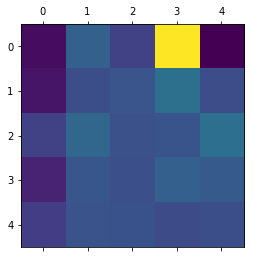

In [67]:
np.set_printoptions(precision=4, suppress=True,)
print(delta - user_1_pct.sort_index().values.reshape(5,1).dot(user_2_pct.sort_index().values.reshape(1,5)))
plt.matshow(delta - user_1_pct.sort_index().values.reshape(5,1).dot(user_2_pct.sort_index().values.reshape(1,5)))

In [53]:
test_corr
delta_mat = np.zeros((5,5))
for i in range(5):
    for j in range(5):
#         print(i,j)
        if test_corr[test_corr['bins_x']==i][test_corr['bins_y']==j]['dist'].count()>0:
            delta_mat[i,j] = test_corr[test_corr['bins_x']==i][test_corr['bins_y']==j]['dist'] - user_1_pct[i]*user_2_pct[j]
        else:
            delta_mat[i,j] = - user_1_pct[i]*user_2_pct[j]
        

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/annahilgard/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [54]:
delta_mat

array([[ -6.01093625e-02,   1.24495103e-02,  -1.70016766e-02,
          1.97200206e-01,  -6.87083222e-02],
       [ -5.33342225e-02,  -4.65409824e-03,   1.01074572e-03,
          2.95936059e-02,  -5.66484396e-03],
       [ -1.63777007e-02,   1.94947224e-02,  -2.48447205e-03,
         -1.52421598e-04,   2.81141638e-02],
       [ -4.27780742e-02,   2.68285829e-03,  -3.49378882e-03,
          1.32059025e-02,   6.17664711e-03],
       [ -2.06521739e-02,  -5.03229433e-04,  -1.47515528e-03,
         -7.37577640e-03,  -5.16304348e-03]])